## Logistic Regression Implementation on (scaled) Reduced Dataset with LDA

Imports

In [1]:
# Utilities
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Models
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\movil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Set random seed for reproductibility

In [2]:
seed = 23

Read clean (scaled data) and reduced dataset

In [3]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [4]:
df_lda = pd.read_csv('../../DimensionalityReductionData/lda.csv')

Keep only the 'averageRating' column and join with LD1 from LDA

In [5]:
df_scaled = df_scaled[['averageRating']]
df_scaled['LD1'] = df_lda['LD1']

In [6]:
df_scaled.head()

,averageRating,LD1
0,1,-0.773971
1,0,-0.931000
2,1,1.084941
3,0,-0.681546
4,0,0.045055


Take sample for (initial) tests

In [7]:
#df_scaled_sample = df_scaled.sample(n=5000, random_state=seed)
df_scaled_sample = df_scaled

Train-Test Split

In [8]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1), 
    df_scaled_sample['averageRating'], test_size=test_size, 
    random_state=seed
)

Save and print metrics

In [9]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None)),
    }
    
    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")
    
    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()
    
    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()
    
    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])
    
    return df_metrics

Model fit

In [10]:
model = LogisticRegression(random_state=seed)
model.fit(X_train, y_train)

LogisticRegression(random_state=23)

In [11]:
predictions = model.predict(X_test)

Metrics for LR_original:
Accuracy: 0.7432
Weighted F1: 0.7428
Weighted Precision: 0.7433
Weighted Recall: 0.7432
Macro-Averaged Precision: 0.7434
Macro-Averaged Recall: 0.7419
F1: [0.7580797  0.72630458]
Precision: [0.74064991 0.74617068]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


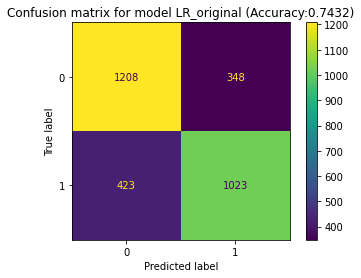

In [12]:
model_metrics = calculate_metrics('LR_original', y_test, predictions)

In [13]:
# Apar warning-uri ptc nu converge daca max_iter e mic (<100)
# Maximu pe care l-am pus e 10k si acolo nu apare niciun warning dar am lasat ca lista
# Ptc modelele cele mai bune sunt la la max_iter <500
warnings.filterwarnings(action='ignore')

## Grid Search with Cross-Validation

In [14]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [10, 100, 200, 500, 100, 1000, 5000],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search_cv = GridSearchCV(estimator=LogisticRegression(random_state=seed),
                               param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_cv = grid_search_cv.best_params_
best_model_cv = grid_search_cv.best_estimator_

Results of the best model 

In [15]:
accuracy_cv = best_model_cv.score(X_test, y_test)

print("Best Hyperparameters:", best_params_cv)
print("Accuracy:", accuracy_cv)

Best Hyperparameters: {'C': 0.01, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7431712191872085


Results of best models Grid Search CV

In [16]:
df_cv = pd.DataFrame(grid_search_cv.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_cv = df_cv[['params', 'mean_test_score']]
df_results_cv_sorted = df_results_cv.sort_values(by='mean_test_score', ascending=False)

print(df_results_cv_sorted.head(5))

                                               params  mean_test_score
56  {'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 's...         0.734194
76  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', ...         0.734194
64  {'C': 0.1, 'max_iter': 200, 'penalty': 'l1', '...         0.734194
60  {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', '...         0.734194
31  {'C': 0.01, 'max_iter': 10, 'penalty': 'l2', '...         0.734194


Metrics for LR_CV1_best:
Accuracy: 0.7432
Weighted F1: 0.7427
Weighted Precision: 0.7434
Weighted Recall: 0.7432
Macro-Averaged Precision: 0.7435
Macro-Averaged Recall: 0.7419
F1: [0.75838295 0.72591539]
Precision: [0.74006116 0.746891  ]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


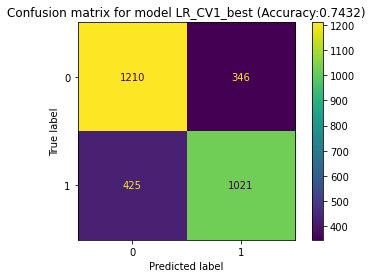

In [17]:
# Use best parameters to make predictions
predictions_cv = best_model_cv.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_CV1_best', y_test, predictions_cv)])

## Grid Search Stratified K Fold Validation

In [18]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

grid_search_skf = GridSearchCV(estimator=LogisticRegression(random_state=seed), 
                           param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search_skf.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params_skf = grid_search_skf.best_params_
best_model_skf = grid_search_skf.best_estimator_

# Evaluate the best model on the test set
accuracy = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters with Stratified K-Fold:", best_params_skf)
print("Accuracy with Stratified K-Fold:", accuracy)


Best Hyperparameters with Stratified K-Fold: {'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
Accuracy with Stratified K-Fold: 0.7431712191872085


Results of the best model 

In [19]:
accuracy_skf = best_model_skf.score(X_test, y_test)

print("Best Hyperparameters:", best_params_skf)
print("Accuracy:", accuracy_skf)

Best Hyperparameters: {'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.7431712191872085


Results of best models Grid Search CV

In [20]:
df_skf = pd.DataFrame(grid_search_skf.cv_results_)

# Show top parameters for LR with Cross Validation Grid Serach
df_results_skf = df_skf[['params', 'mean_test_score']]
df_results_skf_sorted = df_results_skf.sort_values(by='mean_test_score', ascending=False)

print(df_results_skf_sorted.head(5))

                                                params  mean_test_score
57   {'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 's...         0.734194
167  {'C': 100, 'max_iter': 5000, 'penalty': 'l2', ...         0.734111
118  {'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...         0.734111
112  {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'so...         0.734111
113  {'C': 10, 'max_iter': 10, 'penalty': 'l1', 'so...         0.734111


Metrics for LR_skf_best:
Accuracy: 0.7432
Weighted F1: 0.7428
Weighted Precision: 0.7433
Weighted Recall: 0.7432
Macro-Averaged Precision: 0.7434
Macro-Averaged Recall: 0.7419
F1: [0.7580797  0.72630458]
Precision: [0.74064991 0.74617068]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


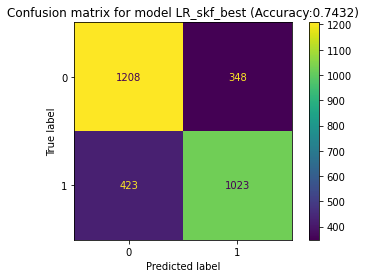

In [21]:
# Use best parameters to make predictions
predictions_skf = best_model_skf.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_skf_best', y_test, predictions_skf)])

Next maybe add elastic search as penalty? only works with saga solver

# Tune with Optuna

In [22]:
def objective(trial):
    # Define the hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_loguniform('C', 0.01, 10.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['liblinear', 'saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [23]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:19:00,181] A new study created in memory with name: no-name-1b9f0f3c-20b5-4166-997e-344ab9193ce5
[I 2024-06-08 00:19:00,205] Trial 0 finished with value: 0.7431712191872085 and parameters: {'penalty': 'l2', 'C': 1.978696921972353, 'max_iter': 354, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:00,222] Trial 1 finished with value: 0.7431712191872085 and parameters: {'penalty': 'l2', 'C': 0.7147547361025183, 'max_iter': 471, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:00,237] Trial 2 finished with value: 0.7431712191872085 and parameters: {'penalty': 'l1', 'C': 0.5871453092844537, 'max_iter': 981, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:00,251] Trial 3 finished with value: 0.7431712191872085 and parameters: {'penalty': 'l1', 'C': 2.9335873033004263, 'max_iter': 664, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7431712191872085.
[

Best Hyperparameters: {'penalty': 'l1', 'C': 0.07180273843352494, 'max_iter': 405, 'solver': 'liblinear'}
Best Accuracy: 0.7441705529646903


In [24]:
# Get best trials
trials_OTP1 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP1 = trials_OTP1.sort_values(by='value', ascending=False).head(10)
top_trials_OTP1

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_penalty,params_solver,state
174,174,0.744171,2024-06-08 00:19:05.054266,2024-06-08 00:19:05.069269,0 days 00:00:00.015003,0.078368,498,l1,liblinear,COMPLETE
21,21,0.744171,2024-06-08 00:19:00.574264,2024-06-08 00:19:00.587266,0 days 00:00:00.013002,0.071803,405,l1,liblinear,COMPLETE
56,56,0.744171,2024-06-08 00:19:01.892263,2024-06-08 00:19:01.907275,0 days 00:00:00.015012,0.014025,177,l1,liblinear,COMPLETE
136,136,0.744171,2024-06-08 00:19:04.082268,2024-06-08 00:19:04.094261,0 days 00:00:00.011993,0.012556,827,l1,liblinear,COMPLETE
163,163,0.744171,2024-06-08 00:19:04.774263,2024-06-08 00:19:04.794264,0 days 00:00:00.020001,0.067725,724,l1,liblinear,COMPLETE
165,165,0.744171,2024-06-08 00:19:04.817267,2024-06-08 00:19:04.833268,0 days 00:00:00.016001,0.079317,381,l1,liblinear,COMPLETE
34,34,0.744171,2024-06-08 00:19:00.863260,2024-06-08 00:19:00.885265,0 days 00:00:00.022005,0.086677,640,l1,liblinear,COMPLETE
169,169,0.744171,2024-06-08 00:19:04.919285,2024-06-08 00:19:04.938263,0 days 00:00:00.018978,0.060205,397,l1,liblinear,COMPLETE
170,170,0.744171,2024-06-08 00:19:04.941264,2024-06-08 00:19:04.963262,0 days 00:00:00.021998,0.077239,873,l1,liblinear,COMPLETE
172,172,0.744171,2024-06-08 00:19:04.998269,2024-06-08 00:19:05.025261,0 days 00:00:00.026992,0.010134,615,l2,liblinear,COMPLETE


Metrics for LR_OPT1_best:
Accuracy: 0.7442
Weighted F1: 0.7437
Weighted Precision: 0.7444
Weighted Recall: 0.7442
Macro-Averaged Precision: 0.7446
Macro-Averaged Recall: 0.7428
F1: [0.75969962 0.72649573]
Precision: [0.7402439  0.74889868]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


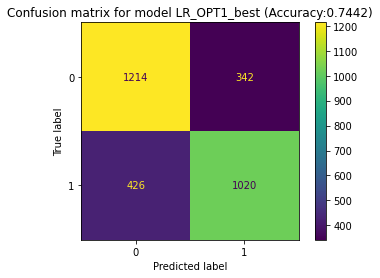

In [25]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt1 = best_model.predict(X_test)
model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT1_best', y_test, predictions_opt1)])

In [26]:
study.best_params

{'penalty': 'l1',
 'C': 0.07180273843352494,
 'max_iter': 405,
 'solver': 'liblinear'}

In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_parallel_coordinate(study)

In [29]:
optuna.visualization.plot_slice(study, params=['penalty', 'C', 'max_iter', 'solver'])

In [30]:
optuna.visualization.plot_param_importances(study)

In [31]:
optuna.visualization.plot_edf(study)

Enlarge 'C' range and add elasticnet parameter (comes with l1_ratio)

In [32]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_loguniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [33]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:19:08,392] A new study created in memory with name: no-name-164acbfe-4fc1-406b-961b-60a25a4e2c27
[I 2024-06-08 00:19:08,421] Trial 0 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:08,439] Trial 1 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 0.07659165484895042, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:08,453] Trial 2 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 0.37133840345513924, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:08,468] Trial 3 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 61.35506425409843, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7431712191872085


In [34]:
# Get best trials
trials_OTP2 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP2 = trials_OTP2.sort_values(by='value', ascending=False).head(10)
top_trials_OTP2

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.743171,2024-06-08 00:19:08.394442,2024-06-08 00:19:08.421446,0 days 00:00:00.027004,61.355064,0.517298,789,elasticnet,saga,COMPLETE
134,134,0.743171,2024-06-08 00:19:11.320672,2024-06-08 00:19:11.336711,0 days 00:00:00.016039,5.635844,0.870727,442,elasticnet,saga,COMPLETE
124,124,0.743171,2024-06-08 00:19:11.087671,2024-06-08 00:19:11.111666,0 days 00:00:00.023995,5.405927,0.087747,612,elasticnet,saga,COMPLETE
125,125,0.743171,2024-06-08 00:19:11.114681,2024-06-08 00:19:11.150669,0 days 00:00:00.035988,0.713634,0.169274,111,elasticnet,saga,COMPLETE
127,127,0.743171,2024-06-08 00:19:11.174670,2024-06-08 00:19:11.194669,0 days 00:00:00.019999,0.112256,0.535513,567,elasticnet,saga,COMPLETE
128,128,0.743171,2024-06-08 00:19:11.196673,2024-06-08 00:19:11.223674,0 days 00:00:00.027001,0.147543,0.477792,465,elasticnet,saga,COMPLETE
129,129,0.743171,2024-06-08 00:19:11.225669,2024-06-08 00:19:11.242666,0 days 00:00:00.016997,0.561933,0.474294,114,elasticnet,saga,COMPLETE
130,130,0.743171,2024-06-08 00:19:11.244666,2024-06-08 00:19:11.261669,0 days 00:00:00.017003,10.892546,0.705562,345,elasticnet,saga,COMPLETE
131,131,0.743171,2024-06-08 00:19:11.262667,2024-06-08 00:19:11.282668,0 days 00:00:00.020001,7.905359,0.465636,174,elasticnet,saga,COMPLETE
132,132,0.743171,2024-06-08 00:19:11.284673,2024-06-08 00:19:11.302685,0 days 00:00:00.018012,7.631269,0.849127,992,elasticnet,saga,COMPLETE


Metrics for LR_OPT2_best:
Accuracy: 0.7432
Weighted F1: 0.7428
Weighted Precision: 0.7433
Weighted Recall: 0.7432
Macro-Averaged Precision: 0.7434
Macro-Averaged Recall: 0.7419
F1: [0.7580797  0.72630458]
Precision: [0.74064991 0.74617068]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


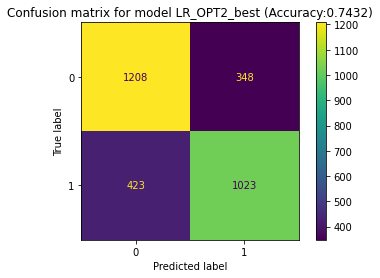

In [35]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt2 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT2_best', y_test, predictions_opt2)])

In [36]:
optuna.visualization.plot_param_importances(study)

Make 'C' interval uniform (as it remains the most important hyperparameter)

In [37]:
def objective(trial):
    # Define the hyperparameters to optimize
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    penalty = trial.suggest_categorical('penalty', ['elasticnet'])
    C = trial.suggest_uniform('C', 0.01, 100.0)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    solver= trial.suggest_categorical('solver', ['saga'])
    
    # Create the logistic regression model with the hyperparameters
    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter,
     solver=solver, l1_ratio=l1_ratio, random_state=seed)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    #score_cross_val = cross_val_score(model, X_train, y_train, cv=5, scoring='precision')

    
    return accuracy

In [38]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=seed))
study.optimize(objective, n_trials=200)

# Get the best hyperparameters and accuracy score
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2024-06-08 00:19:13,454] A new study created in memory with name: no-name-92e1cd38-152d-4063-8273-110a89699f37
[I 2024-06-08 00:19:13,476] Trial 0 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:13,495] Trial 1 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.2823958439671127, 'penalty': 'elasticnet', 'C': 22.112325872532644, 'max_iter': 718, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:13,516] Trial 2 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.16713920310005626, 'penalty': 'elasticnet', 'C': 39.25032222183841, 'max_iter': 656, 'solver': 'saga'}. Best is trial 0 with value: 0.7431712191872085.
[I 2024-06-08 00:19:13,531] Trial 3 finished with value: 0.7431712191872085 and parameters: {'l1_ratio': 0.411

Best Hyperparameters: {'l1_ratio': 0.5172978838465893, 'penalty': 'elasticnet', 'C': 94.69679075544326, 'max_iter': 789, 'solver': 'saga'}
Best Accuracy: 0.7431712191872085


In [39]:
# Get best trials
trials_OTP3 = study.trials_dataframe()
# Sort the dataframe by value (accuracy) in descending order
top_trials_OTP3 = trials_OTP3.sort_values(by='value', ascending=False).head(10)
top_trials_OTP3

,number,value,datetime_start,datetime_complete,duration,params_C,params_l1_ratio,params_max_iter,params_penalty,params_solver,state
0,0,0.743171,2024-06-08 00:19:13.457055,2024-06-08 00:19:13.476086,0 days 00:00:00.019031,94.696791,0.517298,789,elasticnet,saga,COMPLETE
137,137,0.743171,2024-06-08 00:19:15.970610,2024-06-08 00:19:15.984646,0 days 00:00:00.014036,7.303382,0.494852,591,elasticnet,saga,COMPLETE
127,127,0.743171,2024-06-08 00:19:15.804611,2024-06-08 00:19:15.820669,0 days 00:00:00.016058,26.262630,0.535513,567,elasticnet,saga,COMPLETE
128,128,0.743171,2024-06-08 00:19:15.821609,2024-06-08 00:19:15.838609,0 days 00:00:00.017000,29.230015,0.477792,465,elasticnet,saga,COMPLETE
129,129,0.743171,2024-06-08 00:19:15.839641,2024-06-08 00:19:15.853645,0 days 00:00:00.014004,43.747745,0.474294,114,elasticnet,saga,COMPLETE
130,130,0.743171,2024-06-08 00:19:15.854641,2024-06-08 00:19:15.869650,0 days 00:00:00.015009,75.930643,0.705562,345,elasticnet,saga,COMPLETE
131,131,0.743171,2024-06-08 00:19:15.870610,2024-06-08 00:19:15.884646,0 days 00:00:00.014036,72.450796,0.465636,174,elasticnet,saga,COMPLETE
132,132,0.743171,2024-06-08 00:19:15.886650,2024-06-08 00:19:15.901649,0 days 00:00:00.014999,72.067713,0.849127,992,elasticnet,saga,COMPLETE
133,133,0.743171,2024-06-08 00:19:15.903652,2024-06-08 00:19:15.917646,0 days 00:00:00.013994,25.327685,0.445845,244,elasticnet,saga,COMPLETE
134,134,0.743171,2024-06-08 00:19:15.919661,2024-06-08 00:19:15.934649,0 days 00:00:00.014988,68.777096,0.870727,442,elasticnet,saga,COMPLETE


Metrics for LR_OPT3_best:
Accuracy: 0.7432
Weighted F1: 0.7428
Weighted Precision: 0.7433
Weighted Recall: 0.7432
Macro-Averaged Precision: 0.7434
Macro-Averaged Recall: 0.7419
F1: [0.7580797  0.72630458]
Precision: [0.74064991 0.74617068]
classification report
              precision    recall  f1-score   support

     Class 0       0.74      0.78      0.76      1556
     Class 1       0.75      0.71      0.73      1446

    accuracy                           0.74      3002
   macro avg       0.74      0.74      0.74      3002
weighted avg       0.74      0.74      0.74      3002

Confusion Matrix


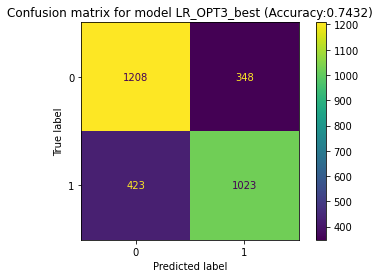

In [40]:
best_trial = study.best_trial
best_model = LogisticRegression(**best_trial.params, random_state=seed)
best_model.fit(X_train, y_train)

predictions_opt3 = best_model.predict(X_test)

model_metrics = pd.concat([model_metrics, calculate_metrics('LR_OPT3_best', y_test, predictions_opt3)])

end

In [41]:
model_metrics

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
LR_original,0.743171,0.742774,0.743309,0.743171,0.743410,0.741909,[0.7580797 0.72630458],[0.74064991 0.74617068]
LR_CV1_best,0.743171,0.742744,0.743351,0.743171,0.743476,0.741860,[0.75838295 0.72591539],[0.74006116 0.746891 ]
LR_skf_best,0.743171,0.742774,0.743309,0.743171,0.743410,0.741909,[0.7580797 0.72630458],[0.74064991 0.74617068]
LR_OPT1_best,0.744171,0.743706,0.744413,0.744171,0.744571,0.742800,[0.75969962 0.72649573],[0.7402439 0.74889868]
LR_OPT2_best,0.743171,0.742774,0.743309,0.743171,0.743410,0.741909,[0.7580797 0.72630458],[0.74064991 0.74617068]
LR_OPT3_best,0.743171,0.742774,0.743309,0.743171,0.743410,0.741909,[0.7580797 0.72630458],[0.74064991 0.74617068]
